In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import optimize

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Fig S2A

Text(0, 0.5, 'P(C|f,N)')

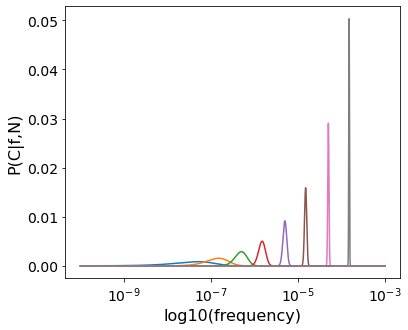

In [2]:

possible_freqs = 10**np.arange(-10,-3,0.001)
num_reads = 20000000

fig, ax = plt.subplots(1,figsize=(6,5))

out_dict = {}
for c in [1,3,10,30,100,300,1000,3000]:
    
    pmf = stats.binom.pmf(c,num_reads,possible_freqs)
    norm = np.sum(pmf)
    
    p = pmf/norm
    
    ax.plot(possible_freqs,p)
    
ax.set_xscale("log")
ax.set_xlabel("log10(frequency)")
ax.set_ylabel("P(C|f,N)")



## Fig S2B

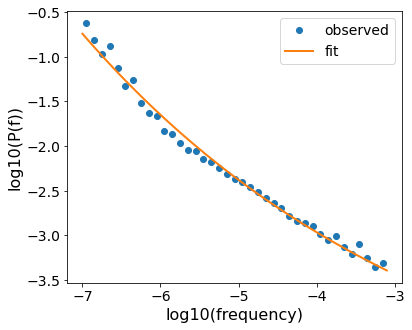

In [3]:

# Read the untreated library counts, recording counts
count_list = []
with open("untreated-library.counts") as f:
    for line in f:
        if line.startswith("#") or line.strip() == "":
            continue

        count = int(line.split()[1])
        count_list.append(count)

# Record the frequencies of all peptides seen
freq_array = np.array(count_list)/np.sum(count_list)
log_freq = np.log10(freq_array)

# Generate a histogram of the log frequencies seen
counts, bins = np.histogram(log_freq,bins=np.arange(-7,-3,0.1))

# Record the bin mid points (in units of log(freq)) and the log the probabilities
# of each frquency
log_mids = (bins[1:]+bins[:-1])/2
log_prob_freq = np.log10(counts/np.sum(counts))

# Fit an exponential to the log(prob of freq) vs. log(mid) plot.  This is empirical: 
# the exponential captures the curvature in this log-log plot and allows us to calculate
# the probability of any frequency with a continuous function. 
def exponential(x,A,k):    
    return A + (np.exp(-x*k))

def exponential_residual(params,x,f_obs):
    return (f_obs - exponential(x,params[0],params[1]))

exponential_fit = optimize.least_squares(exponential_residual,
                                         [1,1],args=[log_mids,log_prob_freq])


fig, ax = plt.subplots(1,figsize=(6,5))
ax.plot(log_mids,log_prob_freq,"o",label='observed')
mids_to_plot = np.arange(-7,-3,0.1)
ax.plot(mids_to_plot,exponential(mids_to_plot,
                                 exponential_fit.x[0],
                                 exponential_fit.x[1]),"-",label="fit",lw=2)

ax.set_xlabel("log10(frequency)")
ax.set_ylabel("log10(P(f))")
ax.legend()



Text(0, 0.5, 'max(P(f|c,N))')

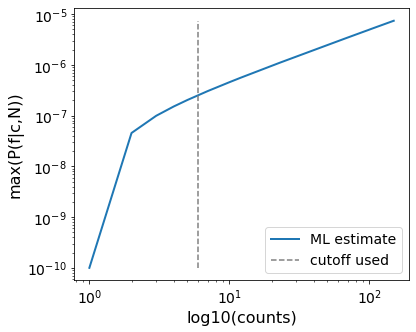

In [4]:

out = []

possible_freqs = 10**np.arange(-10,0,0.001)
counts_to_check = range(1,150)
for c in counts_to_check:  
    
    # PMF for this number of counts given N samples and the possible frequenices
    pmf = stats.binom.pmf(c,num_reads,possible_freqs)
    p_c_given_f = pmf
    
    # Probability of seeing something with frequency f in this library given the 
    # empirical observations. 
    log_prob_f = exponential(np.log10(possible_freqs),
                             exponential_fit.x[0],
                             exponential_fit.x[1])
    p_f = 10**log_prob_f

    max_likelihood_freq = possible_freqs[np.argmax(p_c_given_f*p_f)]
    
    out.append(max_likelihood_freq)
    
fig, ax = plt.subplots(1,figsize=(6,5))
ax.plot(counts_to_check,out,lw=2,label="ML estimate")
ax.plot((6,6),(np.min(out),np.max(out)),'--',color='gray',label="cutoff used")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("log10(counts)")
ax.set_ylabel("max(P(f|c,N))")


